In [364]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


Importing Libraries

In [365]:
# Data handling and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report,confusion_matrix
from sklearn.decomposition import PCA


# Machine learning models
from xgboost import XGBClassifier


In [366]:
df=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

#Copying Data from df to sample_df to carry out EDA
sample_df=df.copy()
test_data=test_df.copy()
print(sample_df.shape)
sample_df.head()

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [367]:
#Checking for Class Imbalance
sample_df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [368]:
#Dividing PassengerId and GroupSize
sample_df['Passenger_Id']=df['PassengerId'].str.split('_').str[0].astype('category')
sample_df['Group_Size']=df['PassengerId'].str.split('_').str[1].astype('category')

#Printing the number of Unique values in Id and Group_Size
print('Unique Values in Passenger_Id:', sample_df['Passenger_Id'].nunique())
print('Unique Values in Group_Size:', sample_df['Group_Size'].nunique())

#Dividing Cabin values
sample_df['Cabin_Deck']=df['Cabin'].str.split('/').str[0].astype('category')
sample_df['Cabin_Num']=df['Cabin'].str.split('/').str[1].astype('category')
sample_df['Cabin_Side']=df['Cabin'].str.split('/').str[2].astype('category')

#Here is how our data looks after above divisions
sample_df.head()
column_count = sample_df.shape[1]
print('No.of Columns in Dataset: ',column_count)

sample_df.head()

Unique Values in Passenger_Id: 6217
Unique Values in Group_Size: 8
No.of Columns in Dataset:  19


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Passenger_Id,Group_Size,Cabin_Deck,Cabin_Num,Cabin_Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,F,1,S


In [369]:
# Dropping unnecessary columns
sample_df.drop(columns=['Name','PassengerId','Cabin'],inplace=True)

# Get the number of columns after dropping
column_count=sample_df.shape[1]

# Print the column count and display the first few rows of the modified DataFrame
print('After Dropping, No. of columns:',column_count)
sample_df.head()


After Dropping, No. of columns: 16


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Passenger_Id,Group_Size,Cabin_Deck,Cabin_Num,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S


In [370]:
#Coverting Remaining Columns to Category
sample_df['HomePlanet']=sample_df['HomePlanet'].astype('category')
sample_df['CryoSleep']=sample_df['CryoSleep'].astype('category')
sample_df['Destination']=sample_df['Destination'].astype('category')
sample_df['VIP']=sample_df['VIP'].astype('category')

#Checking the dtypes of every column
sample_df.dtypes

HomePlanet      category
CryoSleep       category
Destination     category
Age              float64
VIP             category
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Transported         bool
Passenger_Id    category
Group_Size      category
Cabin_Deck      category
Cabin_Num       category
Cabin_Side      category
dtype: object

In [371]:
# Selecting only Categorical columns
categorical_columns=sample_df.select_dtypes(include=['category']).columns
unique_values=sample_df[categorical_columns].nunique()
print(unique_values)

# Selecting only numerical columns
numerical_columns=sample_df.select_dtypes(include=['float64','int64']).columns

HomePlanet         3
CryoSleep          2
Destination        3
VIP                2
Passenger_Id    6217
Group_Size         8
Cabin_Deck         8
Cabin_Num       1817
Cabin_Side         2
dtype: int64


In [372]:
#Adding Group_Size in place of Passenger_ID
sample_df['Group_Size']=sample_df.groupby('Passenger_Id',observed=False)['Passenger_Id'].transform('count')

#Removing Group_Size from Categorical_column
categorical_columns=categorical_columns.drop('Group_Size')
print(categorical_columns)
#Adding to numerical_column
numerical_columns = numerical_columns.insert(len(numerical_columns), 'Group_Size') 


#Taking a Look
print(sample_df['Group_Size'].value_counts())
print('Number of columns in dataset: ',sample_df.shape[1])
sample_df.head()

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Passenger_Id',
       'Cabin_Deck', 'Cabin_Num', 'Cabin_Side'],
      dtype='object')
Group_Size
1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: count, dtype: int64
Number of columns in dataset:  16


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Passenger_Id,Group_Size,Cabin_Deck,Cabin_Num,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,2,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,1,F,1,S


In [373]:
#Handling Missing Data
sample_df.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Passenger_Id      0
Group_Size        0
Cabin_Deck      199
Cabin_Num       199
Cabin_Side      199
dtype: int64

In [374]:
#For cabin we can add another column named no cabin which stores True or False
sample_df['NoCabin']=sample_df['Cabin_Deck'].isna()
sample_df.columns

#Add this into Categorical_columns
categorical_columns=categorical_columns.insert(len(categorical_columns), 'NoCabin')


# Remove Transported from sample_df and make it y
y=sample_df['Transported']
sample_df=sample_df.drop(columns=['Transported'])

#Removing Passenger_Id
sample_df=sample_df.drop(columns=['Passenger_Id'])
categorical_columns=categorical_columns.drop('Passenger_Id')

# Convert Cabin_Num to integer
sample_df['Cabin_Num']=sample_df['Cabin_Num'].astype(float)

categorical_columns=categorical_columns.drop('Cabin_Num')  
numerical_columns=numerical_columns.insert(len(numerical_columns), 'Cabin_Num') 

print(sample_df[numerical_columns].dtypes)  # Data types of numerical columns
print('__________')
print(sample_df[categorical_columns].dtypes)  # Data types of categorical columns

#Taking a look at shapes 
print(sample_df.shape)
print('Categorical_columns: ',categorical_columns.shape)
print('Numerical_columns: ',numerical_columns.shape)



Age             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Group_Size        int64
Cabin_Num       float64
dtype: object
__________
HomePlanet     category
CryoSleep      category
Destination    category
VIP            category
Cabin_Deck     category
Cabin_Side     category
NoCabin            bool
dtype: object
(8693, 15)
Categorical_columns:  (7,)
Numerical_columns:  (8,)


In [375]:
unique_values=sample_df[categorical_columns].nunique()
print(unique_values)

HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
Cabin_Deck     8
Cabin_Side     2
NoCabin        2
dtype: int64


In [376]:
#Appying OHE for all categorical columns
ohe=OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_df=pd.DataFrame(ohe.fit_transform(sample_df[categorical_columns]), columns=ohe.get_feature_names_out())

# Drop original categorical columns and concatenate encoded columns
sample_df=sample_df.drop(columns=categorical_columns).reset_index(drop=True)
sample_df=pd.concat([sample_df, encoded_df], axis=1)

# Check new shape
print(sample_df.shape)
sample_df.head()

(8693, 36)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_Size,Cabin_Num,HomePlanet_Earth,HomePlanet_Europa,...,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Cabin_Deck_nan,Cabin_Side_P,Cabin_Side_S,Cabin_Side_nan,NoCabin_False,NoCabin_True
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,2,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,2,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

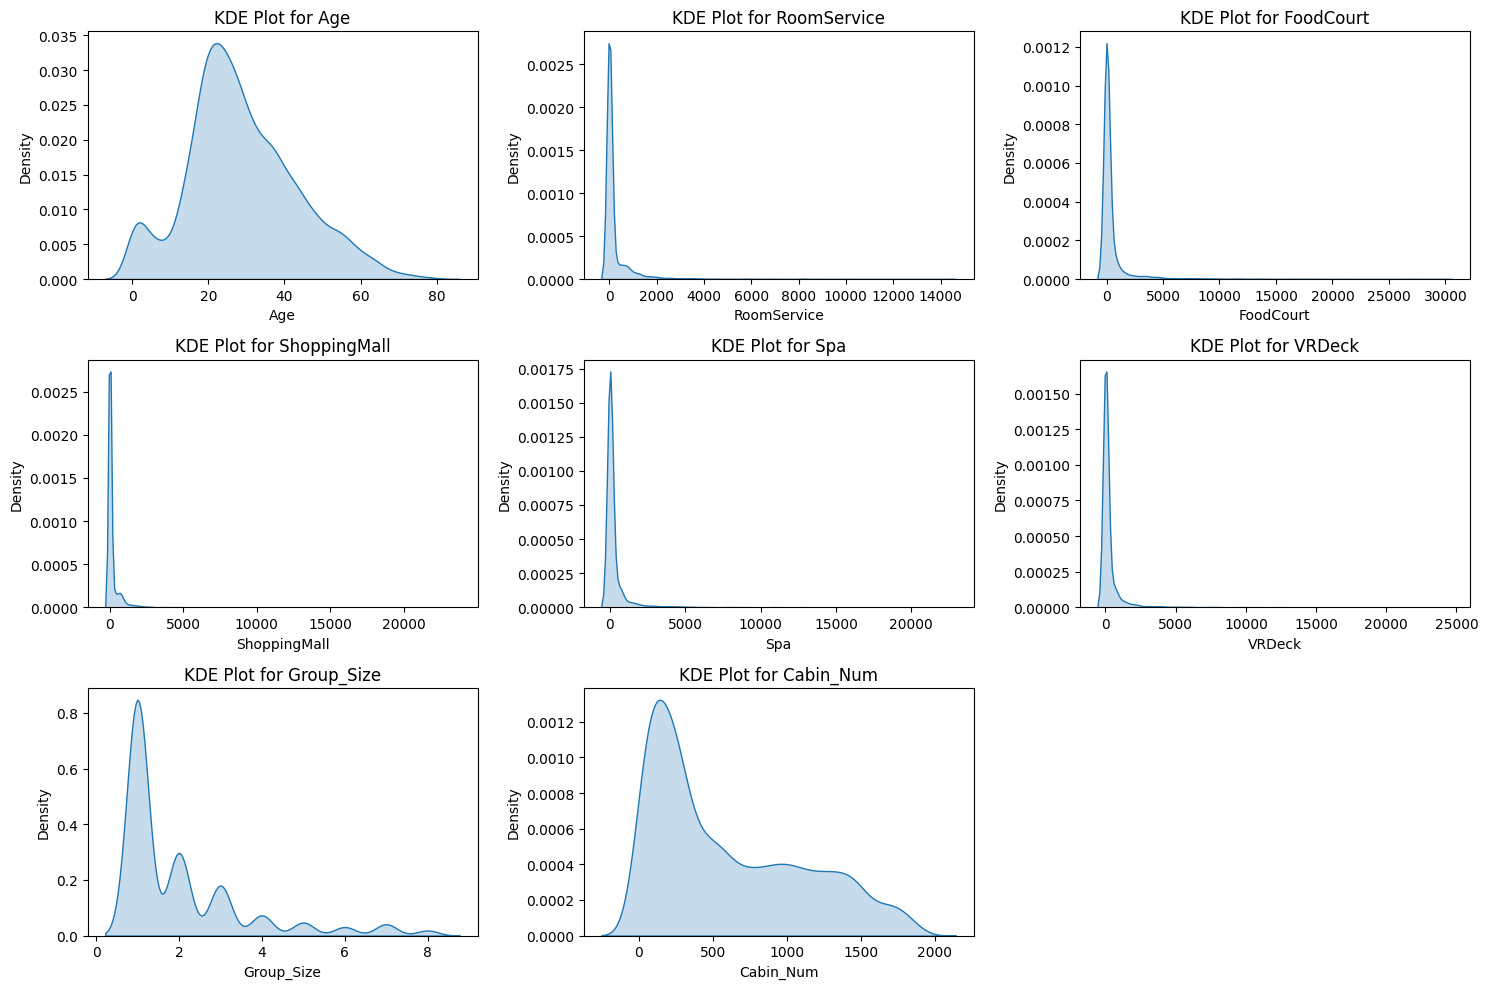

In [377]:
#Plotting Density function graphs
plt.figure(figsize=(15,10))
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns)//3+1,3,i+1)
    sns.kdeplot(sample_df[column],fill=True)
    plt.title(f'KDE Plot for {column}',fontsize=12)

plt.tight_layout()
plt.show()

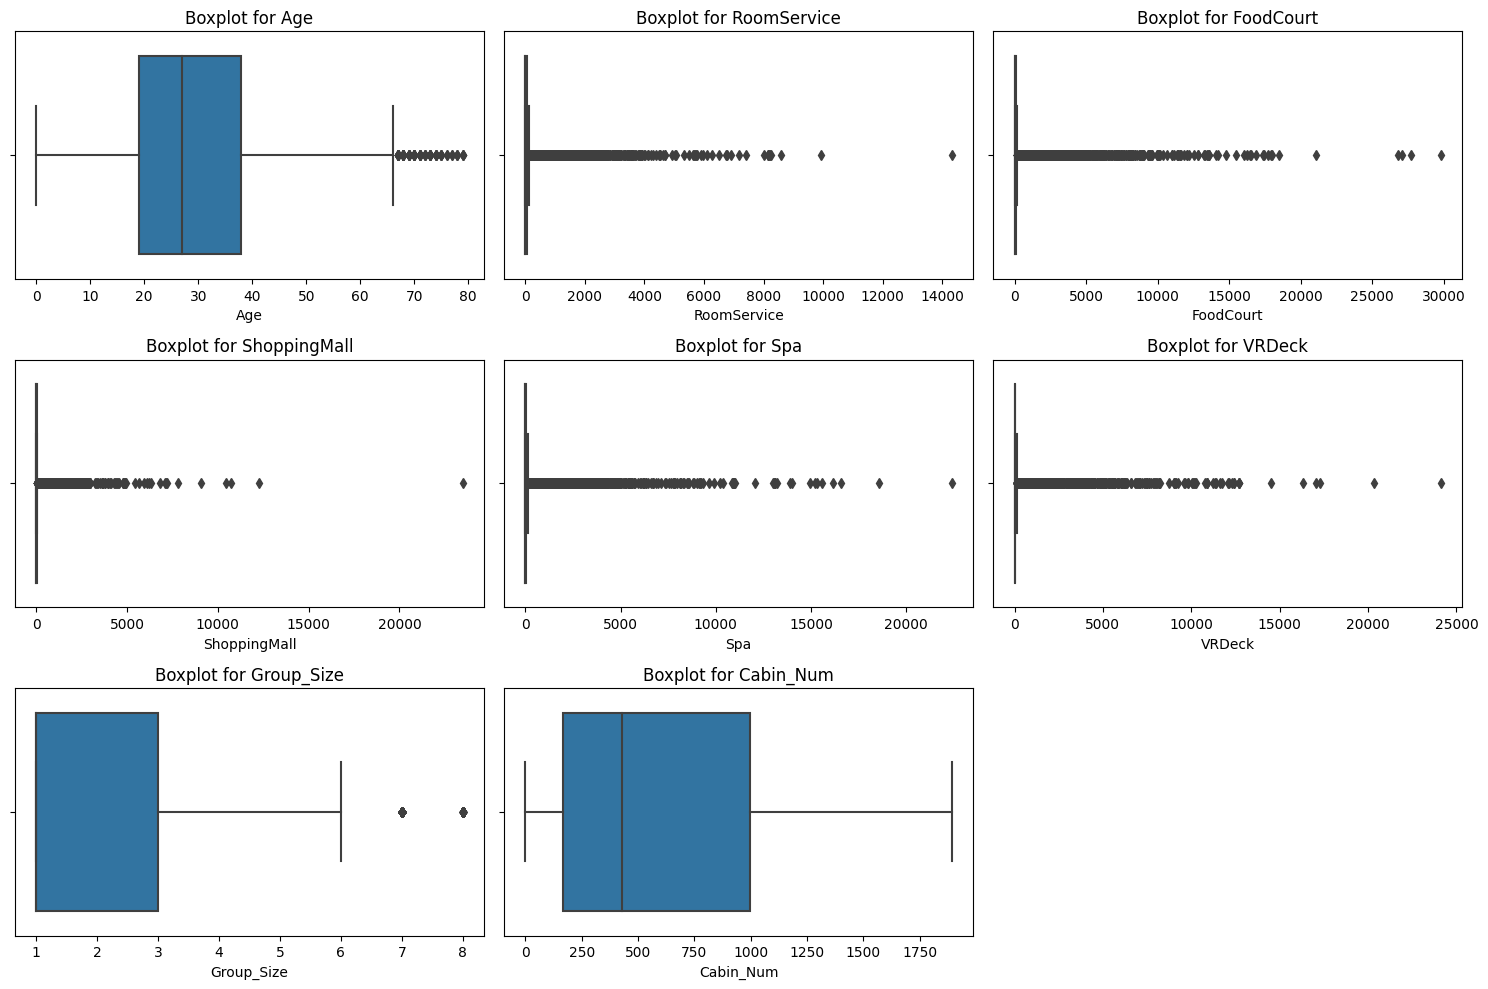

In [378]:
# Creating boxplots for all numerical columns
plt.figure(figsize=(15,10))
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns)//3+1,3,i+1)
    sns.boxplot(x=sample_df[column])
    plt.title(f'Boxplot for {column}',fontsize=12)

plt.tight_layout()
plt.show()


In [379]:
# Define column groups
num_cols=['Age', 'Group_Size']
other_num_cols=[col for col in sample_df.select_dtypes(include=['float64', 'int64']).columns if col not in num_cols]

# Imputers
percentile_imputer=SimpleImputer(strategy='constant', fill_value=np.nanpercentile(sample_df[num_cols], 75))
median_imputer=SimpleImputer(strategy='median')

# Column transformer
preprocessor=ColumnTransformer(transformers=[
    ('percentile',percentile_imputer, num_cols),
    ('median',median_imputer, other_num_cols)
])

# Transform the data
sample_df_processed=preprocessor.fit_transform(sample_df)

# Convert processed data back to DataFrame
sample_df_processed=pd.DataFrame(sample_df_processed, columns=num_cols + other_num_cols)

# Assign the processed values back to sample_df
sample_df[num_cols+other_num_cols]=sample_df_processed


In [380]:
#LabelEncoding for Y
le=LabelEncoder()
y=le.fit_transform(y)
print(y)

[0 1 0 ... 1 0 1]


Steps to be followed:

* Divide the columns based on str.split
* Drop the unnecessary columns
* Create Categorical columns and numerical columns
* Use only tranform method of ohe and Preprocessor(Imputations for missing values) since they are   already trained on train data

In [381]:
#Repeat the above steps for test data

#Dividing PassengerId and GroupSize
test_data['Passenger_Id']=test_data['PassengerId'].str.split('_').str[0].astype('category')
test_data['Group_Size']=test_data['PassengerId'].str.split('_').str[1].astype('category')

#Dividing Cabin values
test_data['Cabin_Deck']=test_data['Cabin'].str.split('/').str[0].astype('category')
test_data['Cabin_Num']=test_data['Cabin'].str.split('/').str[1].astype('category')
test_data['Cabin_Side']=test_data['Cabin'].str.split('/').str[2].astype('category')

# Dropping unnecessary columns
test_data.drop(columns=['Name','PassengerId','Cabin'],inplace=True)

#Coverting Remaining Columns to Category
test_data['HomePlanet']=test_data['HomePlanet'].astype('category')
test_data['CryoSleep']=test_data['CryoSleep'].astype('category')
test_data['Destination']=test_data['Destination'].astype('category')
test_data['VIP']=test_data['VIP'].astype('category')

# Selecting only Categorical columns
categorical_columns=test_data.select_dtypes(include=['category']).columns

# Selecting only numerical columns
numerical_columns=test_data.select_dtypes(include=['float64','int64']).columns

#Adding Group_Size in place of Passenger_ID
test_data['Group_Size']=test_data.groupby('Passenger_Id',observed=False)['Passenger_Id'].transform('count')

#Removing Group_Size from Categorical_column
categorical_columns=categorical_columns.drop('Group_Size')

#Adding to numerical_column
numerical_columns = numerical_columns.insert(len(numerical_columns), 'Group_Size') 

#For cabin we can add another column named no cabin which stores True or False
test_data['NoCabin']=test_data['Cabin_Deck'].isna()

#Add this into Categorical_columns
categorical_columns=categorical_columns.insert(len(categorical_columns), 'NoCabin')

#Removing Passenger_Id
test_data=test_data.drop(columns=['Passenger_Id'])
categorical_columns=categorical_columns.drop('Passenger_Id')

# Convert Cabin_Num to integer
test_data['Cabin_Num']=test_data['Cabin_Num'].astype(float)

categorical_columns=categorical_columns.drop('Cabin_Num')  
numerical_columns=numerical_columns.insert(len(numerical_columns), 'Cabin_Num') 

#Appying OHE for all categorical columns
encoded_df=pd.DataFrame(ohe.transform(test_data[categorical_columns]),columns=ohe.get_feature_names_out())

# Drop original categorical columns and concatenate encoded columns
test_data = test_data.drop(columns=categorical_columns).reset_index(drop=True)
test_data = pd.concat([test_data, encoded_df], axis=1)

# Transform the data
test_data_processed=preprocessor.transform(test_data)

# Convert processed data back to DataFrame
test_data_processed=pd.DataFrame(test_data_processed, columns=num_cols + other_num_cols)

# Assign the processed values back to sample_df
test_data[num_cols+other_num_cols]=test_data_processed

test_data.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_Size,Cabin_Num,HomePlanet_Earth,HomePlanet_Europa,...,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Cabin_Deck_nan,Cabin_Side_P,Cabin_Side_S,Cabin_Side_nan,NoCabin_False,NoCabin_True
0,27.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,19.0,0.0,9.0,0.0,2823.0,0.0,1.0,4.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,31.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,20.0,10.0,0.0,635.0,0.0,0.0,1.0,5.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [382]:
def estimate_components(sample_df) -> int:
    pca = PCA()
    pca.fit(sample_df)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(explained_variance >= 0.95) + 1  
    return num_components

In [383]:
# Estimate the number of components
num_components=estimate_components(sample_df)

# Apply PCA transformation
pca=PCA(n_components=num_components)
sample_df_pca=pca.fit_transform(sample_df)

# Convert PCA result back to DataFrame
pca_columns=[f'PC{i+1}' for i in range(num_components)]
sample_df_pca=pd.DataFrame(sample_df_pca, columns=pca_columns)

# Display transformed DataFrame
print(sample_df_pca.head())

sample_df = sample_df_pca

           PC1          PC2          PC3         PC4         PC5
0  -535.763466  -188.623129   -26.333657 -243.383714 -119.989233
1  -364.851366   174.876089   352.341777 -142.030211 -127.330782
2  4601.791654  2540.432077  4854.048281 -308.445464 -180.791707
3  1608.758738  1477.317814  2291.409892 -209.942492  212.602757
4  -318.469546   133.211869   398.068203   75.577732  -50.662006


In [384]:
# Apply PCA transformation
test_data_pca=pca.transform(test_data)

# Convert PCA result back to DataFrame
pca_columns=[f'PC{i+1}' for i in range(num_components)]
test_data_pca=pd.DataFrame(test_data_pca, columns=pca_columns)

# Display transformed DataFrame
print(test_data_pca.head())

test_data = test_data_pca

           PC1          PC2          PC3         PC4         PC5
0  -535.986308  -188.759309   -26.335064 -243.467380 -119.958111
1   249.124831  1539.073964  2058.793809 -300.823427 -150.847250
2  -535.774157  -188.630976   -26.336117 -243.397399 -119.992063
3  5773.384304 -2326.328436  -375.381734 -183.879388  -77.999510
4  -539.059192  -183.259859   -16.140036  -83.800775  494.600525


In [385]:
# Split data into train and test sets
X_train,X_test,y_train,y_test=train_test_split(sample_df,y,test_size=0.2,random_state=42,stratify=y)

# Initialize XGBoost Classifier
xgb_clf=XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_clf.fit(X_train,y_train)

y_pred = xgb_clf.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.7947
Precision: 0.7678
Recall: 0.8493
F1 Score: 0.8065
Confusion Matrix:
[[638 225]
 [132 744]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       863
           1       0.77      0.85      0.81       876

    accuracy                           0.79      1739
   macro avg       0.80      0.79      0.79      1739
weighted avg       0.80      0.79      0.79      1739



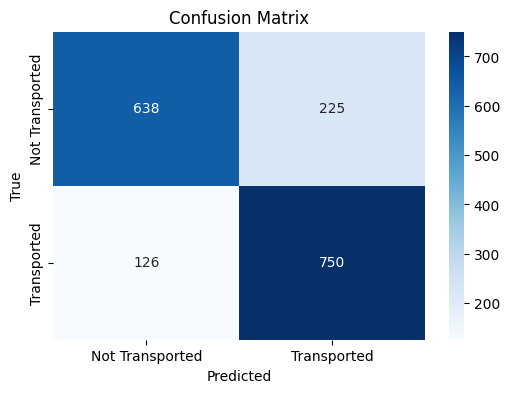

In [392]:
#Heatmap of confusion_Matrix
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Transported', 'Transported'], yticklabels=['Not Transported', 'Transported'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [386]:
#Performing GridSearchCV

# Hyperparameter grid
param_grid={
    'n_estimators':[100, 200],       
    'max_depth':[3, 6, 10],           
    'learning_rate':[0.01, 0.1, 0.2]  
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(xgb_clf, param_grid,cv=5,scoring='accuracy',verbose=1,n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:",grid_search.best_params_)

# Train final model with best parameters
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.7982


In [387]:
# Make predictions on the test dataset
test_predictions=best_xgb.predict(test_data)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'], 
    'Transported': test_predictions 
})

submission['Transported']=submission['Transported'].astype(bool) 
submission.to_csv('submission.csv',index=False)
